# Building a Model in Helipad

In this walkthrough, we’ll build a very simple model of two goods where decentralized trading results in agents converging on an equilibrium price. Each period, agents pair off randomly and see if they can become better off by trading. If so, they trade. If not, they do nothing. In just a few rounds, agents – without knowing anything besides the people they’re trading with – converge on a single price for one good in terms of the other, and become better off in the process. You can see the [final model code here](https://github.com/charwick/helipad/blob/master/sample-models/pricediscover.py).

In order to get started, we’ll need to import the main Helipad class and initialize it, along with a few other functions we’ll need along the way.

In [2]:
from helipad import Helipad
from helipad.utility import CobbDouglas
from math import sqrt, exp, floor
import random

heli = Helipad()
heli.name = 'Price Discovery'

The variable `heli` will be the main way we’ll interact with the model. Helipad operates using [*hooks*](https://helipad.dev/glossary/hooks/), meaning that Helipad runs a loop and gives you the opportunity to insert your own logic into it. In this model, we’ll insert code to run in three places: (1) at the beginning of each period, (2) when an agent is created, and – most importantly – (3) each time an agent is activated. 

## Outlining the Model

First, we’ll want to lay out the logic of the model, as well as the kinds of data we’ll want to collect as it runs. A rough outline might look like this:

1. At the beginning of the model, each agent gets a random amount of two goods. We’ll call them Shmoo (M) and Soma (H).
2. Agents have a Cobb-Douglas utility function over the two: *U*=*M*<sup>0.5</sup>*H*<sup>0.5</sup>. This means that more of each makes agents better off, but at a decreasing rate.
3. Each period, each agent finds a random partner.
4. If the agents in a pair find they can both become better off by trading, they trade some amount of Soma for some amount of Shmoo. Otherwise they do nothing.
5. At the end of each period, we’ll be interested in recording (1) how well off everyone is, (2) how much shmoo and soma got traded, and (3) the terms of trade – specifically, how divergent they are.

Helipad will take care of (3) for us:

In [3]:
heli.order = 'match'

This line configures the model to match agents each period and run them through a [`match`](https://helipad.dev/hooks/match) hook that we'll define later, rather than stepping through them individually. `'match'` is equivalent to `'match-2'`. We could also set [`heli.order`](https://helipad.dev/functions/model/#order) to `'match-3'` if we wanted it to group in triplets, or any other number. But for a trading model, and for most others, pairs are what we want.

For the others, we’ll hook (1) and (2) into [agent initialization](https://helipad.dev/hooks/agentinit), (4) into [agent activation](https://helipad.dev/hooks/agentstep), and (5) we’ll gather afterward.

Starting with (1), we might want to control the aggregate ratio of shmoo to soma before each run. Helipad has a control panel on which we can place parameters that control the model. Before the function then, we’ll tell the Helipad object to add a parameter that we can control, and whose value we can use in our agents’ logic.

In [4]:
heli.addParameter('ratio', 'Log Endowment Ratio', 'slider', dflt=0, opts={'low': -3, 'high': 3, 'step': 0.5}, runtime=False)

#Make sure we don't get stray agents
heli.params['num_agent'].opts['step'] = 2
heli.params['num_agent'].opts['low'] = 2

heli.addGood('shmoo','#11CC00', (1, 1000))
heli.addGood('soma', '#CC0000', lambda breed: (1, floor(exp(heli.param('ratio'))*1000)))

Line 1 tells Helipad to add a slider parameter named ‘ratio’, with a default value of 0, and that moves in increments of 0.5 between -3 and 3. We'll be able to adjust this value in the control panel and use the value in the model. The `runtime` argument tells Helipad not to allow the parameter to be changed while the model is running, since it only affects the endowment at the beginning.

Helipad automatically creates slider parameters for number of agents (more specifically, it creates a parameter for each *primitive*, but we aren't creating new primitives in this model, so we use the default primitive titled `agent`). In the fourth and fifth lines, we want to edit the options of this automatically created parameter so we can only create an even number of agents. Since this is a matching model, we don't want leftover agents! 

We can access this automatically created parameter in Helipad's `params` property. The [`opts` property](https://helipad.dev/functions/param/#opts) of the [`Param` object](https://helipad.dev/functions/param/) that we access this way corresponds to the `opts` argument in the [`addParameter()` method](https://helipad.dev/functions/model/addparameter/) earlier. Here, we change the increment and the low value to equal 2.

Lines 7 and 8 tell Helipad that our economy has two goods, named `'shmoo'` and `'soma'`. The [`addGood`](https://helipad.dev/functions/model/addgood) function gives each agent object a [`'stocks`' property](https://helipad.dev/functions/agent/#stocks), a dict with two items – `'soma'` and `'shmoo'` – that keep track of how much of each good each agent has. The second argument is a [hex color](https://www.w3schools.com/colors/colors_picker.asp); this tells Helipad to draw shmoo with a green line, and soma with a red.

The third argument gives each agent an initial endowment. There are several ways we can do this. First, we could pass a number to give each agent the same amount. Second, we can pass a tuple with two items, and Helipad will endow the agent with a random amount between those two numbers. This is what we do for shmoo. For soma, on the other hand, we use the third possibility: a function that uses logic as complicated as necessary to determine how much each agent is to start with. In this case we want to endow the agent with a random amount between 0 and $1000 \times e^{ratio}$, with `heli.param('ratio')` retrieving the value of the slider parameter from line 1 (The value is wrapped in `floor()` in order to make sure we pass a whole number to `randint()`). `'ratio'`, therefore, controls the aggregate quantity of soma as compared to shmoo.

Why not just pass a tuple for soma too? The lambda function is necessary here becuase we want Helipad to check the value of the `ratio` parameter each time agents are initialized, since we might change the value between runs. If we simply used the tuple that the lambda function returns as the third argument, it would evaluate the expression using the value of the parameter *when the good was first added*. Since that's before we had a chance to change it in the control panel, it would lock us into the parameter's default value.

Now it's time to start using [hooks](https://helipad.dev/glossary/hooks/). [`agentInit`](https://helipad.dev/hooks/agentinit/) allows you to hook a function to run each time an agent is initialized. The easiest way to write a hook is to add the `@heli.hook` decorator to a function with the name of the hook.

In [5]:
@heli.hook
def agentInit(agent, model):
	agent.utility = CobbDouglas(['shmoo', 'soma'])

(Alternatively, we could name the function whatever we want, and decorate it with `@heli.hook('agentInit')`, or add it manually afterward with `heli.addHook('agentInit', agentInit)`, but the basic decorator is the easiest way.)

The `agentInit` hook passes two arguments to its function: the `agent` object – the agent being instantiated – and the general `model` object. Since Helipad takes care of matching and stocks of goods for us, all we need to do here is to give each agent a Cobb-Douglas utility function over two goods, with the default exponents of 0.5.

## The `match` Function

Next, we’ll move to the meat of the model, steps (3) and (4) above. Since we instantiated a match model above, this will be the [`match`](https://helipad.dev/hooks/match) function, which pairs agents off (if we had set `heli.order` to `'random'` or `'linear'` we would be using the [`agentStep`](https://helipad.dev/hooks/agentstep) hook).

Before we get to the function, however, we'll need to break out some microeconomics to determine how the two partners will interact. The basic tool to figure out opportunities for gains from trade is called an *Edgeworth Box*. 

In an Edgeworth box, we plot two agents’ space of two goods, but we invert the second and place it on top of the first. Agent 1’s possessions are counted from the bottom-left axis, and agent 2’s are counted from the top-right axis. The height and width of the box, therefore, represent the total of the two goods between them, and a point in the box – for example, point E – represents four pieces of information: agent 1’s stock of shmoo ($H_1^E$), agent 1’s stock of soma ($M_1^E$), agent 2’s stock of shmoo ($H_2^E$), and agent 2’s stock of soma ($M_2^E$).

In this example, point E is our *endowment point*. These four values represent the amount of shmoo and soma, respectively, that the agents bring into the trade. Suppose this is period 1, so agent 2 has very little soma ($M_2^E$ is very small), agent 1 has a great deal, and they both have middling amounts of shmoo.

The blue curves represent the Cobb-Douglas utility function we gave agent 1 earlier. Each curve, what is called an *indifference curve*, indicates all the points on the curve that would give agent 1 the same utility. It slopes downward due to the fact that at any point, agent 1 would be willing to trade *some* amount of soma for additional shmoo. Blue curves further out from O1 indicate higher utility. The same pertains to the red lines for agent 2, except that lines further out from O2 will indicate higher utility.

At the endowment point E, agents 1 and 2 have utility corresponding to $U_1^E$ and $U_2^E$, respectively. How do we know if they can become better off by trading?

One result from microeconomics is that any two agents can become more satisfied by trading if their *marginal rates of substitution* between the two goods are different – that is, if the slopes of their indifference curves at E are different. This means that there exists some range of prices where agent 1 would be willing to sell something and agent 2 would be willing to buy it (and vice versa in terms of the other good), and both would be happy with this arrangement (i.e. the indifference curve would be pushed further out).

Marginal rates of substitution are equal between the two when their indifference curves are tangent to each other. The goal, then, is to find some trade of soma for shmoo that moves the two agents to a point in the Edgeworth box where their indifference curves would be tangent to one another.

The *contract curve* above is the set of all points in the Edgeworth box where the two curves would be tangent (*note that the contract curve is only a straight line between the two origins when the exponents on the Cobb-Douglas utility function are equal, as we ensured when instantiating the CobbDouglas object above*). In addition, we’ll want to find a point on the contract curve inside the lens made by the indifference curves sprouting from point E, as any other point would make one of them worse off (though if they had started from that point, there would be no further gains from trade).

Any point on the contract curve inside that lens will do. For our purposes though, we’ll just split the difference. We’ll find the points where $U_1^E$ and $U_2^E$ hit the contract curve, and trade enough soma and shmoo to move to the midpoint between the two – namely, point T, which gives both parties higher utility $U_1^T$ and $U_2^T$.

We write this logic into the `match` function as follows:

In [6]:
@heli.hook
def match(agents, primitive, model, stage):
	u1e = agents[0].utility.calculate(agents[0].stocks)
	u2e = agents[1].utility.calculate(agents[1].stocks)
	
	#Get the endpoints of the contract curve
	#Contract curve isn't linear unless the CD exponents are both 0.5. If not, *way* more complicated
	cc1Soma = u1e * (sum([a.stocks['soma'] for a in agents])/sum([a.stocks['shmoo'] for a in agents])) ** 0.5
	cc2Soma = sum([a.stocks['soma'] for a in agents]) - u2e  * (sum([a.stocks['soma'] for a in agents])/sum([a.stocks['shmoo'] for a in agents])) ** 0.5
	cc1Shmoo = sum([a.stocks['shmoo'] for a in agents])/sum([a.stocks['soma'] for a in agents]) * cc1Soma
	cc2Shmoo = sum([a.stocks['shmoo'] for a in agents])/sum([a.stocks['soma'] for a in agents]) * cc2Soma
	
	#Calculate demand: choose a random point on the contract curve
	r = random.random()
	somaDemand = r*cc1Soma + (1-r)*cc2Soma - agents[0].stocks['soma']
	shmooDemand = r*cc1Shmoo + (1-r)*cc2Shmoo - agents[0].stocks['shmoo']
	
	#Do the trades
	if abs(somaDemand) > 0.1 and abs(shmooDemand) > 0.1:
		agents[0].trade(agents[1], 'soma', -somaDemand, 'shmoo', shmooDemand)
		agents[0].lastPrice = -somaDemand/shmooDemand
		agents[1].lastPrice = -somaDemand/shmooDemand
	else:
		agents[0].lastPrice = None
		agents[1].lastPrice = None
	
	#Record data
	agents[0].utils = agents[0].utility.calculate(agents[0].stocks)
	agents[1].utils = agents[1].utility.calculate(agents[1].stocks)

The `match` hook sends four arguments: a list of matched agents (in this case two of them), their [primitive](https://helipad.dev/glossary/#primitive), the model object, and the current model stage. Since we haven't created any new primitives, `primitive` will always equal `'agent'`, the default primitive. We could also have the model run in multiple stages by setting `heli.stages`, but since we haven't done that, `stage` will always equal 1.

Lines 3-11 find the endpoints of the contract curve. 3, 8, and 10 solve for the point where agent 1’s endowment utility sits on the contract curve. If $U=M^{0.5}H^{0.5}$, then $U_1^E = \sqrt{M_1^E H_1^E}$, which the `CobbDouglas` object we instantiated earlier as `agent.utility` can calculate automatically. Solving for H and setting it equal to the equation for the contract curve gives us the endpoint, which is denoted by the point (`cc1Soma`, `cc1Shmoo`), which we calculate on lines 8 and 10. An identical process is played out for agent 2 on lines 4, 9, and 11 to find the other endpoint where $U_2^E$ intersects the contract curve.

Having found these two endpoints, the third block selects a random point on the contract curve and subtracts the existing endowment in order to find the quantities necessary to move from point E to a point T. Geometrically, we can demonstrate that this gives both parties higher utility starting from *any point not already on the contract curve*. Note that, geometrically, in order to get to the contract curve, one of either `somaDemand` and `shmooDemand` will be positive, and the other negative.

Provided the amounts to be traded aren’t minuscule, line 16 actually executes the trade. The `trade()` method of the agent class transfers `-somaDemand` soma from the agent, and gives `shmooDemand` shmoo to partner. Note that the third and fifth arguments of `trade()` expect a supply and a demand for the two goods from the perspective of the first agent, which means it expects both to be positive or both to be negative (*Note: if one argument were negative and the other positive, one agent would be paying its partner one good in order to take some of the other good. One of these good, therefore, would be a bad rather than a good*). In lines 3-16, however, we calculated the agent’s demand for both goods, one of which will be negative (i.e. a supply of it). We therefore reverse `somaDemand` in the third argument to indicate a supply of soma. 

We also record `lastPrice` and `utils` as properties of each agent, updating every period, in order to collect and display them later. The `if` block tells the agents to record the terms of trade as a `lastPrice` property, *if* they traded. Otherwise, the `else` block indicates that they didn’t trade, and shouldn’t be counted as part of that period’s average. The final two lines record the agents’ utilities from their new endowments of shmoo and soma.

## Data Collection and Display

For our purposes, we’ll be interested in keeping track of (1) average utility, (2) the volume of trade each period, and (3) the terms of trade. If we did things correctly, we’ll expect to see (1) utility rising, since agents won’t trade if they don’t become better off; (2) the volume of trade falling, since any two agents that find each other will be closer to the contract curve in later periods than in earlier periods, and (3) convergence on a single price.

Any data we plot visually will have to be recorded with a *reporter,* which returns one value per model period.  Fortunately Helipad keeps tracks the volume of trade automatically when we use the [`trade()` function](https://helipad.dev/functions/agent/trade/) and registers the reporter for us. We've also kept track of utility and terms of trade at the end of our previous function, so now we need reporters to tell Helipad how to aggregate and display those properties. In our case, in addition to the volume of trade, we want Helipad to record *average* utility and *average* price, along with maximum and minimum prices (to see dispersion).

Helipad already records average utility by default by looking at the `utils` property of agents, so once we’ve given agents a utility in lines 8 an 9 above, the plotting is already taken care of. That leaves just the prices. In order to set up a plot, we’ll have a four-step process:

1. Aggregate the data each period,
2. Register the reporter so Helipad keeps track of it,
3. Set up a plot on which we can display series together, and
4. Register the reporter as a series, so we can visualize it, and place it on a plot.

Each of these is associated with a function. For 1, we use [`heli.data.agentReporter()`](https://helipad.dev/functions/data/agentreporter), which cycles over all the agents and computes a statistic based on a property name. We’ll use this in combination with [`heli.data.addReporter()`](https://helipad.dev/functions/data/addreporter) for step 2, which makes sure to record the result of `heli.data.agentReporter` each period and put it in the data output.

In [7]:
heli.data.addReporter('ssprice', heli.data.agentReporter('lastPrice', 'agent', stat='gmean', percentiles=[0,100]))

The second argument of `addReporter` must be a function that takes the model object. `agentReporter` generates such a function that calculates the geometric mean of the value of the `lastPrice` property of each agent (Geometric mean, rather than arithmetic mean, is appropriate for relative prices as 0.1 should be an equal distance from 1 as 10), along with additional plots for the 0<sup>th</sup> and 100<sup>th</sup> percentiles (maximum and minimum values). This column of the data can then be plotted and referred back to in Helipad’s data functions with the name `'ssprice'`.

In order to visualize our data in real time, we’ll need somewhere to put it – step 3. This is called a plot, and is registered using the [`addPlot`](https://helipad.dev/functions/model/addplot) function. Finally, for step 4, we’ll create a series, which tells Helipad to display a reporter on the plot we specify.

In [ ]:
heli.addPlot('price', 'Price', logscale=True, selected=True)
heli.addSeries('price', 'ssprice', 'Soma/Shmoo Price', '#119900')

Line 1 gives us a place to put our price series, lets us refer to it as `‘price’` and labels it `‘Price’`. Since we’re looking at a price ratio, for the same reason we used a geometric mean, we’ll also want to display it on a logarithmic scale. Finally, line 2 tells Helipad to use the `ssprice` reporter we set up earlier and draw it on the `'price'` plot, label it ‘Soma/Shmoo Price’, and color it `#119900`, which is a medium-dark green.

All of the data registered as a reporter can be accessed algorithmically within the model, or after the model runs, to integrate with the statistical techniques from the previous chapter. The entire data output can be accessed as a Pandas dataframe using [`heli.data.dataframe`](https://helipad.dev/functions/data/#dataframe). Particular values of a series can be accessed using [`heli.data.getLast()`](https://helipad.dev/functions/data/getlast) (see below).

## Final Touches

The model as it stands is ready to run. Just a few more niceties before finishing. First, because this model is one of a decentralized convergence to equilibrium, it won’t be interesting to keep running it once it gets sufficiently close to equilibrium.

Helipad has a built-in configuration parameter `'stopafter'` that displays as a [checkentry](https://helipad.dev/functions/checkentry/) in the control panel. If `stopafter` is `False`, the model runs forever. If `stopafter` is an integer, the model stops after that many periods.

However, `stopafter` can also be set to a function, in order for us to establish more complex stopping conditions. The function takes the model object as its only parameter. It returns `False` to keep going, and `True` on some condition to stop the model. Note that this disables the parameter in the control panel.

In [9]:
#Stop the model when we're basically equilibrated
def stopCondition(model):
	return model.t > 1 and model.data.getLast('demand-shmoo') < 20 and model.data.getLast('demand-soma') < 20
heli.param('stopafter', stopCondition)

In this case, we stop the model when (1) the current time is greater than 1, (2) when the total shmoo traded is less than 20, and (3) when the total soma traded is also less than 20. Given that we gave each agent a random endowment of up to 1000 of each, and that the default number of agents is 50, a total volume of trade under 20 is quite low, comparatively.

Finally, a line to make sure only the plots with actual series are selected by default in the control panel.

In [10]:
for p in ['demand', 'utility']: heli.plots[p].active(True)

We also set the refresh rate parameter to 1 in order to see it play out live. Ordinarily this would make the model quite slow, but because it equilibrates so quickly (less than 20 periods), the default refresh rate of 20 would just show the final result.

In [11]:
heli.param('updateEvery', 1)

And with that, our model is complete! Launch the control panel if you want to adjust the parameters visually before running the model. 

In [ ]:
heli.launchCpanel()

Once we've set our parameters to our liking, we can actually run the model. [`heli.start()`](https://helipad.dev/functions/model/start/) will run the model without the plots; this starts the model along with the plotting.


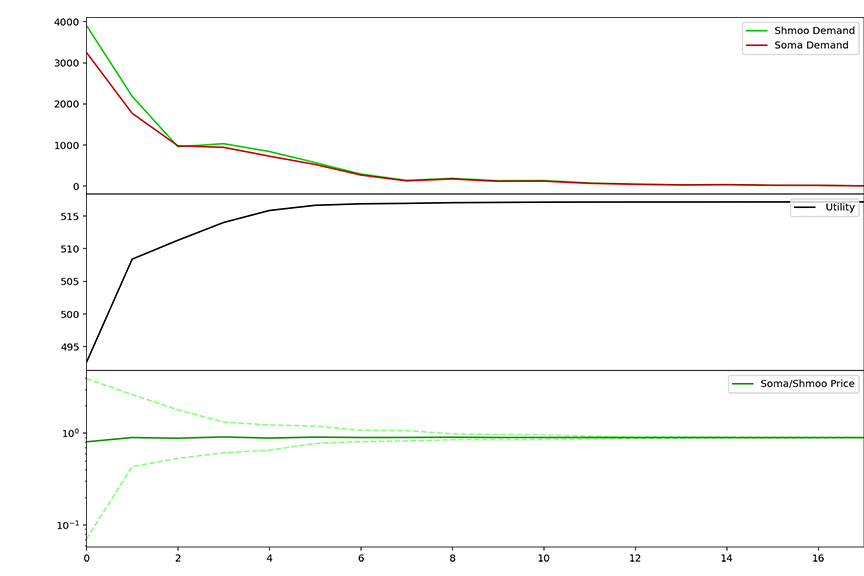

In [15]:
heli.launchPlots()

From this output, it looks like all three of our predictions were validated: (1) utility is rising as agents accomplish more trade, (2) price dispersion narrows as agents converge on an equilibrium price, and (3) the volume of trade declines as agents get closer and closer to equilibrium. It only takes about 15 periods to get a total volume of trade below 20!

From here you can explore the model in various ways:

1. Adjust the parameters in the control panel and re-run the model by running the last line again. See how the endowment ratio affects the equilibrium price, for example.
2. Click on the top plot with the `demand` series and press 'L' to toggle a logarithmic scale on the vertical axis. The resulting lines are approximately linear, meaning the demand function with respect to time takes the form *e*<sup>-*t*</sup>.
3. Add other settings to see how they affect the model. For example, add a slider parameter to control the probability that an agent trades in a given period (i.e. only execute the `match` function with a certain probability). If only half of agents trade each period, for example, the convergence to equilibrium would be slower. Or you might split the difference on the contract curve differently, to see how differences in bargaining power affect the process of equilibration.

One final note: all this code will also work as a standalone Python app with a Tkinter frontend if you run it as a file. The only difference is that the last line `heli.launchPlots()` is unnecessary outside of a Jupyter notebook, as the Tkinter control panel provides a button to launch the plots.

[**See the model code put together ▸**](https://github.com/charwick/helipad/blob/master/sample-models/pricediscover.py)